In [30]:
# Clean and parse logs

import json
import pandas as pd
import pendulum

def parse_payload_line(line):
    parts = line.split()
    return dict(
        timestamp=pendulum.parse(parts[0]),
        user=parts[1],
        method=parts[2],
        url=parts[3],
        download_time=float(parts[4] if parts[4] != '-' else '0'))

def parse_plain(filename):
    '''Parses a plain logfile.
    
    Example log line:
    
        2019-02-13T02:42:55.285Z - GET /i/happiness-celcom_no_contract 39.748 -
    '''
    data = []
    lines = open(filename).readlines()
    for line in lines:
        if 'GET' in line or 'POST' in line:
            data.append(parse_payload_line(line))
    return data

def parse_gcloud_json(filename):
    '''Parses a json logfile, downloaded with `gcloud logging read`.
    
    Example log entry:  
    
        {
        "insertId": "148s1vig213eisn",
        "labels": {
          "compute.googleapis.com/resource_name": "fluentd-gcp-v3.1.0-tvb7n",
          "container.googleapis.com/namespace_name": "default",
          "container.googleapis.com/pod_name": "shell-ui-5f95d6c967-wrsjf",
          "container.googleapis.com/stream": "stdout"
        },
        "logName": "projects/big-graph-gc1/logs/shell-ui",
        "receiveTimestamp": "2019-02-14T12:25:21.974264599Z",
        "resource": {
          "labels": {
            "cluster_name": "shell-ui",
            "container_name": "shell-ui",
            "instance_id": "5293138180524779692",
            "namespace_id": "default",
            "pod_id": "shell-ui-5f95d6c967-wrsjf",
            "project_id": "big-graph-gc1",
            "zone": "europe-west1-b"
          },
          "type": "container"
        },
        "severity": "INFO",
        "textPayload": "2019-02-14T12:25:21.289Z - HEAD / 0.981 -\n",
        "timestamp": "2019-02-14T12:25:21Z"
        }
    
    '''
    
    logs = json.loads(open(filename).read())
    data = []
    for log in logs:
        line = log['textPayload']
        if 'GET' in line or 'POST' in line:
            data.append(parse_payload_line(line))
    return data

            
# celcom_logs = parse_plain('celcom_20190214.log')
# demo_logs = parse_gcloud_json('demosite_20190214.log')

In [31]:
# Selecting the log entries for the statistics

def dashboard_request(url):
    return ((url.startswith('/i/') or url.startswith('/userdata')) 
            and not ('auth_callback' in url or 'session_state' in url))

def dashboard_requests(logs):
    return [log for log in logs if dashboard_request(log['url'])]



demo_logs = dashboard_requests(parse_gcloud_json('demosite_20190214.log'))


In [32]:
# Categorizing log entries

def is_export(log):
    '''Downloading segment'''
    return '_action=download' in log['url']

def is_save_filter(log):
    '''Saving or deleting a filter'''
    return log['method'] == 'POST' and log['url'].startswith('/userdata')

def is_ingredient(log):
    '''Ingredient page load'''
    return log['url'].startswith('/i/ingredient-')

def is_trend(log):
    '''Trends page load'''
    return log['url'].startswith('/i/trends-') and not '_action' in log['url']

def is_segmentation(log):
    '''Segmentation page load'''
    return log['url'].startswith('/i/happiness-') and not '_action' in log['url']

def is_page(log):
    return is_ingredient(log) or is_trend(log) or is_segmentation(log)

def is_relevant(log):
    return is_page(log) or is_export(log) or is_save_filter(log)

# Parsing log entries
def bu_of(log):
    '''Only for toplevel urls, where the bu is at the end'''
    url = log['url']
    return url[url.find('-')+1:] 
    
def day_of(log):
    return str(log['timestamp'].date())

def type_of(log):
    if is_export(log): return 'export'
    if is_save_filter(log): return 'save filter'
    if is_ingredient(log): return 'ingredient page'
    if is_segmentation(log): return 'segmentation page'
    if is_trend(log): return 'trends page'
    print(log)
    return 'unknown'

In [33]:
# Data prep for statistics

def categorize(logs):
    return [dict(
        day=day_of(log),
        user=log['user'],
        what=type_of(log),
        bu=bu_of(log) if is_page(log) else '-'
    ) for log in logs if is_relevant(log)]

final = categorize(demo_logs)

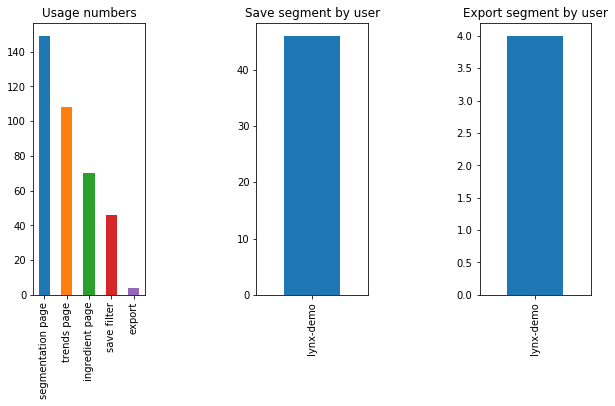

In [34]:
# Display values

df = pd.DataFrame(final)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(10,5))

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)

df['what'].value_counts().plot(ax=axes[0], kind='bar', title='Usage numbers')
df[df['what'] == 'save filter']['user'].value_counts().plot(ax=axes[1], kind='bar', title='Save segment by user')
df[df['what'] == 'export']['user'].value_counts().plot(ax=axes[2], kind='bar', title='Export segment by user')

In [35]:
print(df.to_string())

                    bu         day         user               what
0    generic_broadband  2019-02-14        admin  segmentation page
1       generic_mobile  2019-02-14    lynx-demo  segmentation page
2       generic_mobile  2019-02-14    lynx-demo        trends page
3       generic_mobile  2019-02-14    lynx-demo        trends page
4       generic_mobile  2019-02-14    lynx-demo  segmentation page
5               custom  2019-02-13    lynx-demo  segmentation page
6               custom  2019-02-13            -  segmentation page
7    generic_broadband  2019-02-13    lynx-demo  segmentation page
8       generic_mobile  2019-02-13    lynx-demo    ingredient page
9       generic_mobile  2019-02-13    lynx-demo  segmentation page
10      generic_mobile  2019-02-13    lynx-demo        trends page
11      generic_mobile  2019-02-13    lynx-demo        trends page
12                   -  2019-02-13    lynx-demo        save filter
13      generic_mobile  2019-02-13    lynx-demo        trends 